In [1]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np

## CART算法（classification and regression tree）
## 定义节点

In [2]:
class node:
    def __init__(self, fea=-1, val=None, res=None, right=None, left=None):
        self.fea = fea  # 特征
        self.val = val  # 特征对应的值
        self.res = res  # 叶节点标记
        self.left = left
        self.right = right


## 一、回归树(最小二乘回归树)

In [3]:
class CART_REG:
    def __init__(self, epsilon=0.1, min_sample=10):
        self.epsilon = epsilon
        self.min_sample = min_sample
        self.tree = None

    def fit(self, X_data, y_data):
        self.tree = self.__buildTree(X_data, y_data)
        
        
    def predict(self, x):
        # 对输入变量进行预测
        def helper(x, tree):
            if tree.res is not None:
                return tree.res
            else:
                if x[tree.fea] <= tree.val:
                    branch = tree.left
                else:
                    branch = tree.right
                return helper(x, branch)
 
        return helper(x, self.tree)

        
    def __buildTree(self, X_data, y_data):
         # 递归构建二叉树
        if y_data.shape[0] < self.min_sample:
            return node(res=self.leaf(y_data))
        best_err, best_split, subsets_inds = self.__getBestSplit(X_data, y_data)
        if subsets_inds is None:
            return node(res=self.__leaf(y_data))
        if best_err < self.epsilon:
            return node(res=self.__leaf(y_data))
        else:
            left = self.__buildTree(X_data[subsets_inds[0]], y_data[subsets_inds[0]])
            right = self.__buildTree(X_data[subsets_inds[1]], y_data[subsets_inds[1]])
            return node(fea=best_split[0], val=best_split[1], right=right, left=left)
        
    def __getBestSplit(self, X_data, y_data):
        # 求最优切分点
        best_err = self.__err(y_data)
        best_split = None
        subsets_inds = None
        for fea in range(X_data.shape[1]):
            for val in X_data[:, fea]:
                set1_inds, set2_inds = self.__split(fea, val, X_data)
                if len(set1_inds) < 2 or len(set2_inds) < 2:  # 若切分后某个子集大小不足2，则不切分
                    continue
                now_err = self.__err(y_data[set1_inds]) + self.__err(y_data[set2_inds])
                if now_err < best_err:
                    best_err = now_err
                    best_split = (fea, val)
                    subsets_inds = (set1_inds, set2_inds)
        return best_err, best_split, subsets_inds

        
     
    def __split(self, fea, val, X_data):
        # 根据某个特征，以及特征下的某个取值，将数据集进行切分
        set1_inds = np.where(X_data[:, fea] <= val)[0]
        set2_inds = list(set(range(X_data.shape[0]))-set(set1_inds))
        return set1_inds, set2_inds
    
    def __err(self, y_data):
        # 求方差
        return y_data.var() * y_data.shape[0]

        
    def __leaf(self, y_data):
        # 叶节点取值，为子数据集输出y的均值
        return y_data.mean()


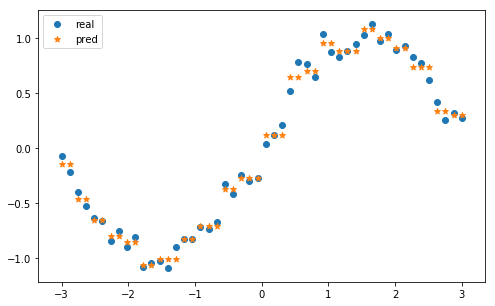

In [4]:
X_data_raw = np.linspace(-3, 3, 50)
np.random.shuffle(X_data_raw)
y_data = np.sin(X_data_raw)
X_data = np.transpose([X_data_raw])
y_data = y_data + 0.1 * np.random.randn(y_data.shape[0])
cr = CART_REG(epsilon=1e-4, min_sample=1)
cr.fit(X_data, y_data)
res = []
for i in range(X_data.shape[0]):
    res.append(cr.predict(X_data[i]))
plt.figure(figsize=(8,5))
p1 = plt.scatter(X_data_raw, y_data)
p2 = plt.scatter(X_data_raw, res, marker='*')
plt.legend([p1,p2],['real','pred'],loc='upper left')
plt.show()


## 二、分类树（基尼指数）

In [5]:
class CART_CLF:
    def __init__(self, epsilon=1e-3, min_sample=1):
        self.epsilon = epsilon
        self.min_sample = min_sample  # 叶节点含有的最少样本数
        self.tree = None
        
    def fit(self, X_data, y_data):
        # 训练模型，CART分类树与ID3最大的不同是，CART建立的是二叉树，每个节点是特征及其对应的某个值组成的元组
        # 特征可以多次使用
        splits_set = []
        for fea in range(X_data.shape[1]):
            unique_vals = np.unique(X_data[:, fea])
            if unique_vals.shape[0] < 2:
                continue
            elif unique_vals.shape[0] == 2:  # 若特征取值只有2个，则只有一个切分点，非此即彼
                splits_set.append((fea, unique_vals[0]))
            else:
                for val in unique_vals:
                    splits_set.append((fea, val))
        self.tree = self.__buildTree(splits_set, X_data, y_data)

    
    def score(self, X_test, y_test):
        res_score = 0
        for x, y in zip(X_test, y_test):
            if self.__score(x, self.tree) == y:
                res_score += 1
      
        print('right rate: %.3f' % (res_score / y_test.shape[0]))
         
            
    def __score(self, x, node):
        if node.res is not None:
            return node.res
        else:
            if x[node.fea] == node.val:
                branch = node.left   #'是' 返回左孩子
            else:
                branch = node.right
            return self.__score(x, branch) 
       
              
    
    def __buildTree(self, splits_set, X_data, y_data):
        if y_data.shape[0] < self.min_sample:  # 数据集小于阈值直接设为叶节点
            return node(res=Counter(y_data).most_common(1)[0][0])
        best_split, best_set, min_gini = self.__bestSplit(splits_set, X_data, y_data)
        if best_split is None:  # 基尼指数下降小于阈值，则终止切分，设为叶节点
            return node(res=Counter(y_data).most_common(1)[0][0])
        else:
            splits_set.remove(best_split)
            left = self.__buildTree(splits_set, X_data[best_set[0]], y_data[best_set[0]])
            right = self.__buildTree(splits_set, X_data[best_set[1]], y_data[best_set[1]])
            return node(fea=best_split[0], val=best_split[1], right=right, left=left)

    
    def __bestSplit(self, splits_set, X_data, y_data):
        # 返回所有切分点的基尼指数，以字典形式存储。键为split，是一个元组，第一个元素为最优切分特征，第二个为该特征对应的最优切分值
        pre_gini = self.__getGini(y_data)
        subdata_inds = defaultdict(list)  # 切分点以及相应的样本点的索引
        for split in splits_set:
            for ind, sample in enumerate(X_data):
                if sample[split[0]] == split[1]:
                    subdata_inds[split].append(ind)
        min_gini = 1000
        best_split = None
        best_set = None
        for split, data_ind in subdata_inds.items():
            set1 = y_data[data_ind]  # 满足切分点的条件，则为左子树
            set2_inds = list(set(range(y_data.shape[0])) - set(data_ind))
            set2 = y_data[set2_inds]
            if set1.shape[0] < 1 or set2.shape[0] < 1:
                continue
            now_gini = self.__getFeaGini(set1, set2)
            if now_gini < min_gini:
                min_gini = now_gini
                best_split = split
                best_set = (data_ind, set2_inds)
        if abs(pre_gini - min_gini) < self.epsilon:  # 若切分后基尼指数下降未超过阈值则停止切分
            best_split = None
        return best_split, best_set, min_gini

    
    
    def __getGini(self, y_data):
        # 计算基尼指数
        c = Counter(y_data)
        return 1 - sum([(val / y_data.shape[0]) ** 2 for val in c.values()])
 
    def __getFeaGini(self, set1, set2):
        # 计算某个特征及相应的某个特征值组成的切分节点的基尼指数
        num = set1.shape[0] + set2.shape[0]
        return set1.shape[0] / num * self.__getGini(set1) + set2.shape[0] / num * self.__getGini(set2)


In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
X = load_iris().data
y = load_iris().target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = CART_CLF()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

right rate: 0.956
